In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,roc_auc_score, roc_curve
#Over Sampling and under sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore");

In [2]:
df = pd.read_csv("180_inj_cyc_e114_deneme.csv")

In [3]:
df.head()

,Unnamed: 0,date,tmpMoldZone25,timCool1,tmpBarrel2Zone3,tmpMoldZone3,tmpBarrel2Zone4,tmpFlange1,tmpMoldZone4,tmpBarrel2Zone1,...,sfc,frcClamp,timPlasticisation1,timPlasticisation2,reason,prsInjectionHyd1,prsTransferHyd1,strCushion1,strPlasticisation1,strTransfer1
0,21690,2021-01-18T23:28:17.000,241.0,40.06,238.5,264.6,238.3,251.2,264.9,248.0,...,[],7149.8,7.24,37.25,[],NaN,NaN,NaN,NaN,NaN
1,28917,2021-02-09T14:31:52.000,241.1,42.53,230.1,260.8,230.0,249.8,261.0,240.0,...,[],7915.0,6.17,23.86,[],NaN,NaN,NaN,NaN,NaN
2,28918,2021-02-09T14:36:04.000,241.0,42.55,230.2,260.8,229.9,250.8,260.9,240.1,...,[],7947.1,6.17,23.99,[],NaN,NaN,NaN,NaN,NaN
3,28919,2021-02-09T14:27:43.000,241.0,42.55,230.2,260.9,230.1,251.0,261.0,240.1,...,[],7927.9,6.09,24.02,[],NaN,NaN,NaN,NaN,NaN
4,28920,2021-02-09T14:30:31.000,241.0,42.55,230.0,260.9,230.1,252.6,261.0,240.0,...,[],7943.8,6.18,24.03,[],NaN,NaN,NaN,NaN,NaN


In [4]:
df['reason'] = df['reason'].replace(['[]'],0)
df['reason'][df['reason'] != 0] = 1
df = df.astype({"reason": int})

In [5]:
df.columns

Index(['Unnamed: 0', 'date', 'tmpMoldZone25', 'timCool1', 'tmpBarrel2Zone3',
       'tmpMoldZone3', 'tmpBarrel2Zone4', 'tmpFlange1', 'tmpMoldZone4',
       'tmpBarrel2Zone1', 'tmpFlange2', 'tmpMoldZone1', 'volCushion1',
       'tmpBarrel2Zone2', 'tmpMoldZone2', 'volCushion2', 'prsBackSpec2',
       'prsBackSpec1', 'spdInjection1', 'tmpMoldZone9', 'spdInjection2',
       'tmpMoldZone7', 'tmpMoldZone8', 'tmpOil', 'tmpMoldZone5',
       'tmpMoldZone6', 'tmpMoldZone19', 'cntCycle', 'tmpMoldZone18',
       'volTransfer2', 'stsMachine', 'tmpMoldZone15', 'volTransfer1',
       'tmpMoldZone14', 'tmpMoldZone17', 'tmpMoldZone16', 'timTransfer2',
       'timTransfer1', 'velPlasticisation2', 'velPlasticisation1',
       'timMoldClose', 'tmpBarrel1Zone5', 'tmpMoldZone22', 'tmpBarrel1Zone4',
       'tmpMoldZone21', 'tmpMoldZone24', 'tmpBarrel1Zone6', 'tmpMoldZone23',
       'prsPomp1', 'tmpBarrel1Zone1', 'prsPomp2', 'tmpBarrel1Zone3',
       'tmpMoldZone20', 'tmpBarrel1Zone2', 'volShot1', 'volPlasti

<AxesSubplot:>

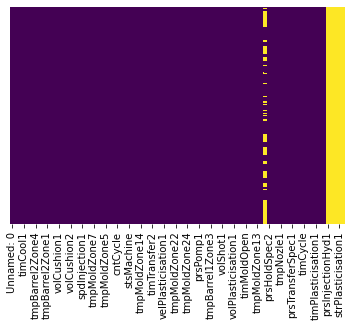

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
drop_list = ['Unnamed: 0', 'date', 'cntCycle','stsMachine','timestamp','sfc','decMold','prsInjectionHyd1','prsTransferHyd1','strCushion1','strPlasticisation1','strTransfer1']

<AxesSubplot:>

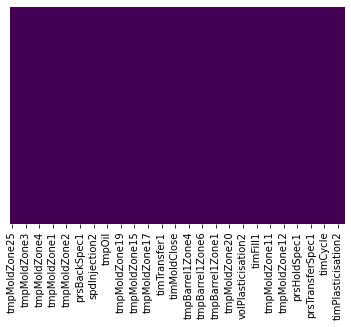

In [8]:
df = df.drop(drop_list, axis=1)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df['reason'].value_counts()

0    36329
1     7053
Name: reason, dtype: int64

In [10]:
sns.countplot(x='0:OK 1:NOK',data=df)

ValueError: Could not interpret input '0:OK 1:NOK'

<AxesSubplot:>

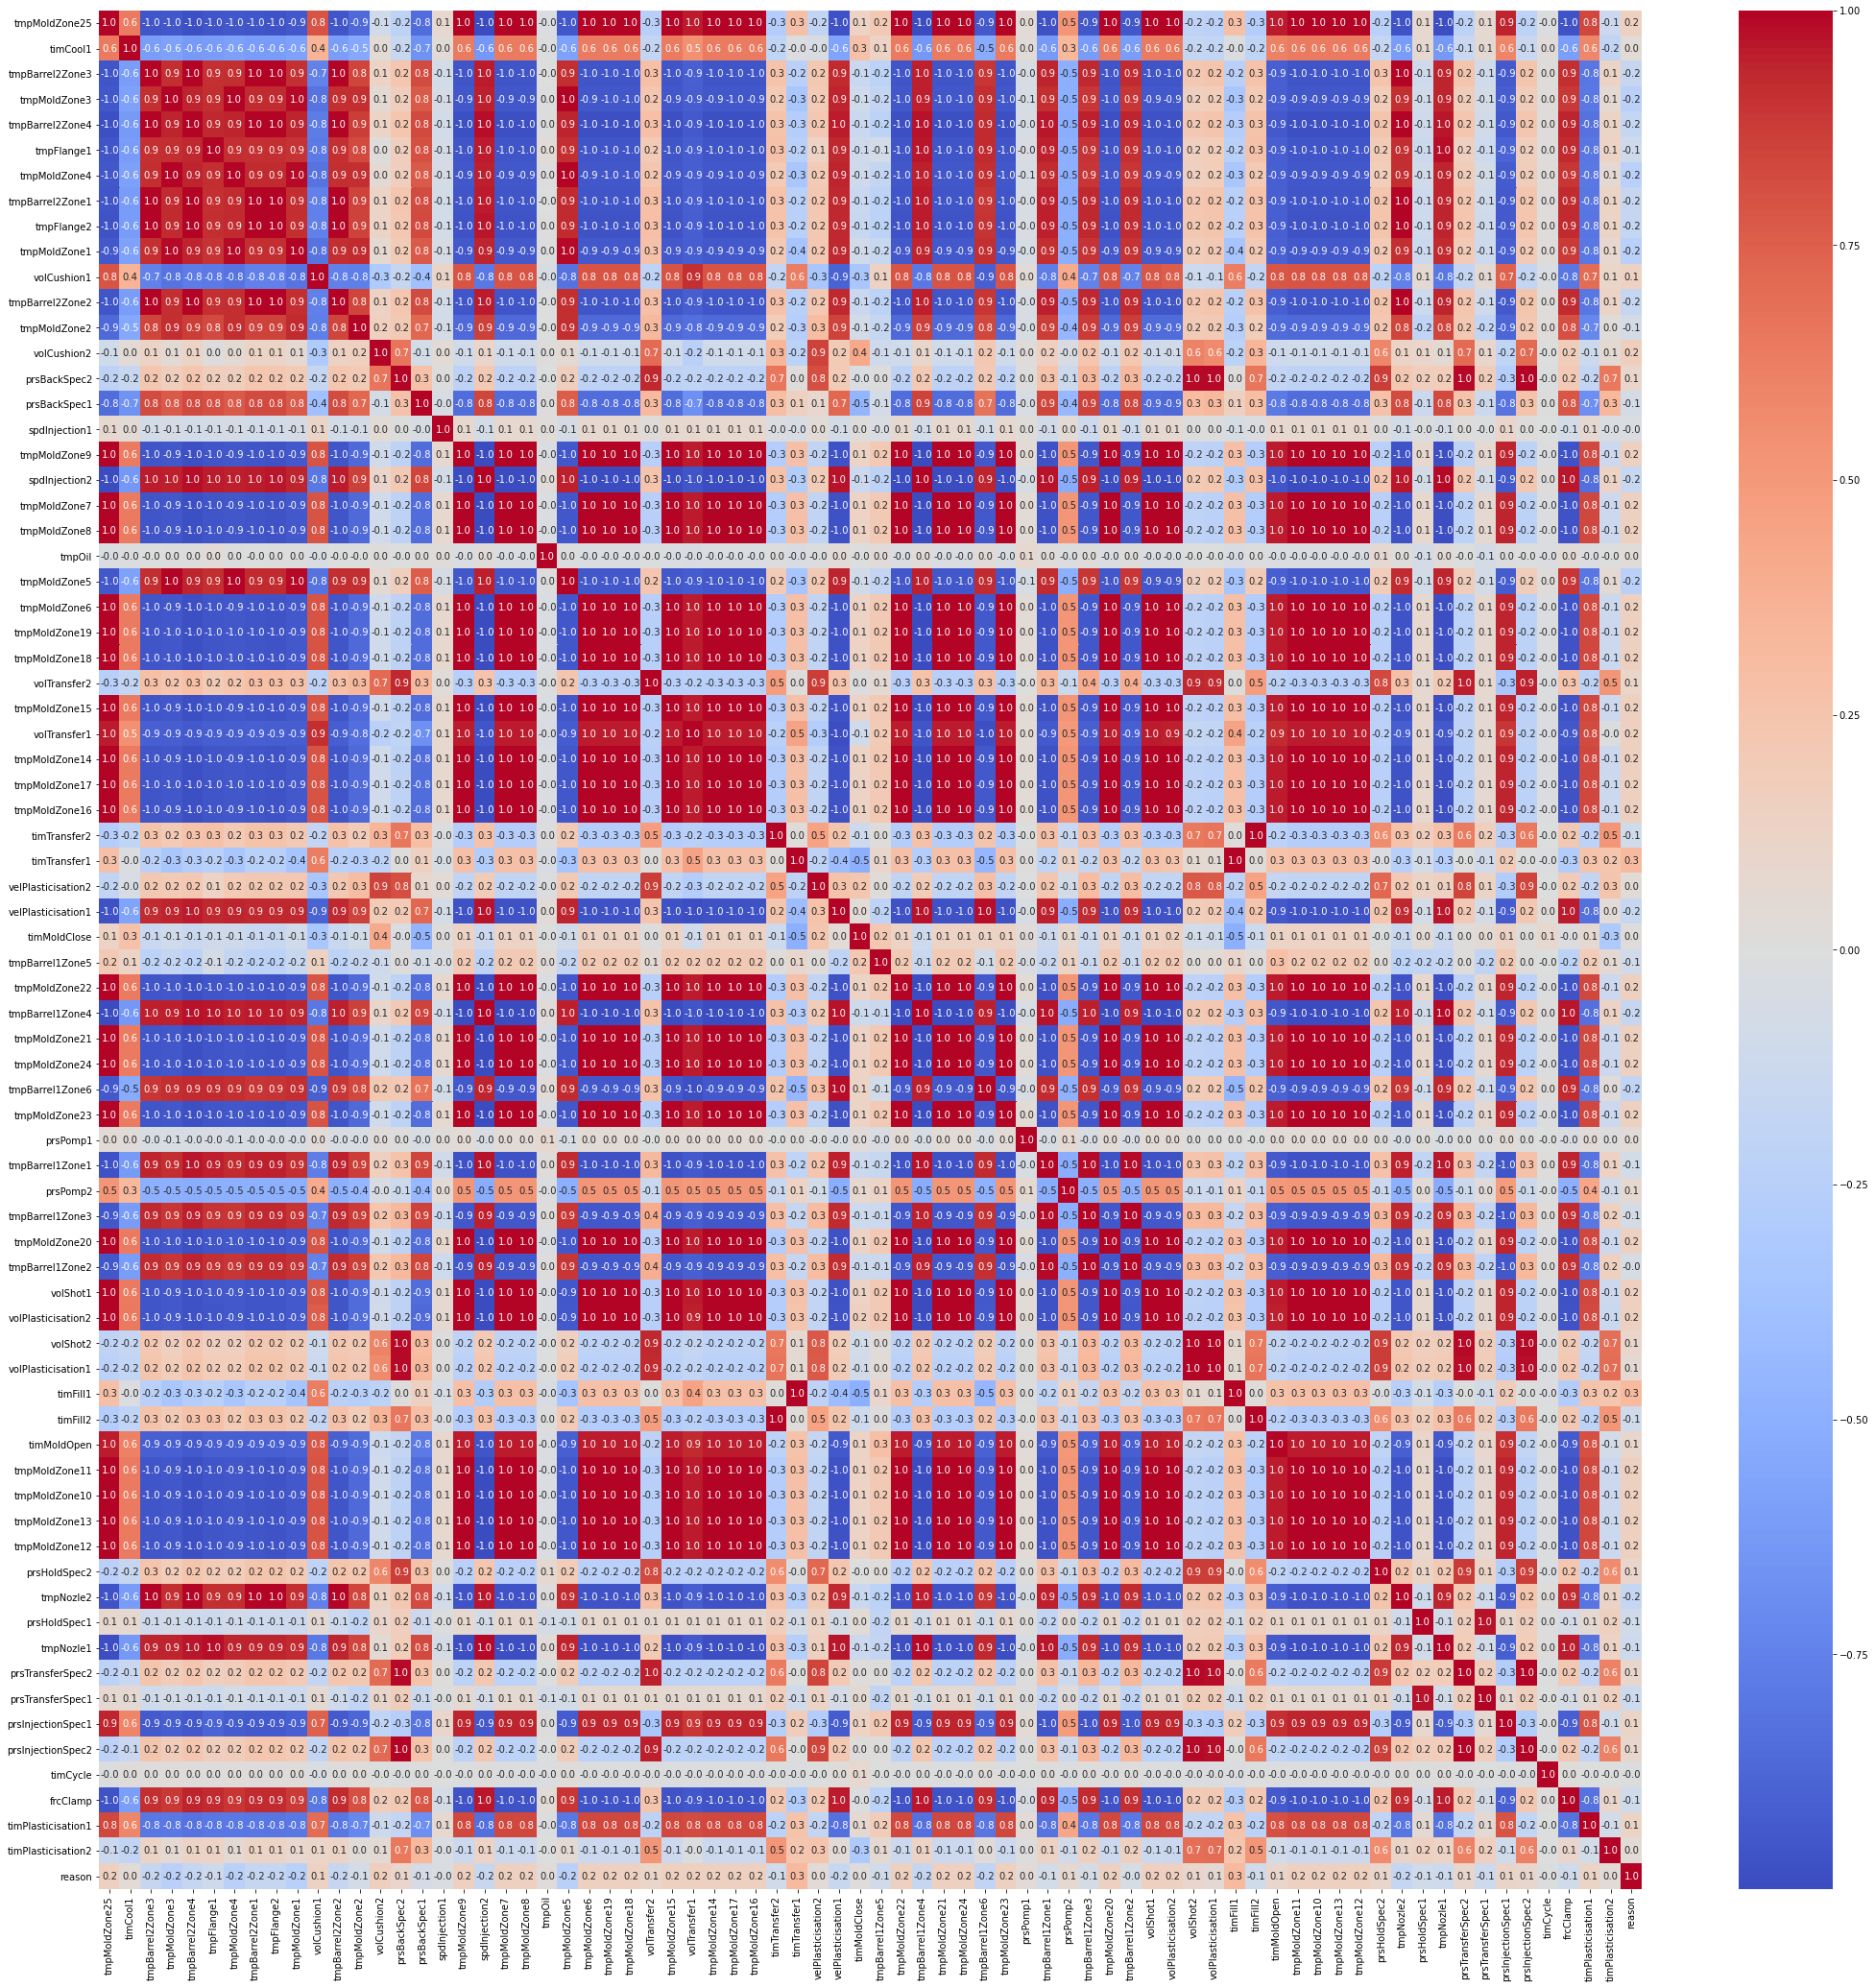

In [11]:
fig, ax = plt.subplots(figsize=(36,36))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm', fmt='.1f')

In [11]:
#Class count
count_class_0, count_class_1 = df.reason.value_counts()
#Divide by class
df_class_0 = df[df['reason'] == 0]
df_class_1 = df[df['reason'] == 1]

In [12]:
#Random Under-Sampling

In [13]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under.reason.value_counts())

Random under-sampling:
1    7053
0    7053
Name: reason, dtype: int64


In [14]:
df1 = df_test_under[df_test_under.reason==1]
df0 = df_test_under[df_test_under.reason==0]

In [15]:
df_test = pd.concat([df1[:500] , df0[:500]], join="inner")
df_train = pd.concat([df1[500:] , df0[500:]], join="inner")

In [16]:
y = df_train['reason']
X = df_train.drop(['reason'], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

In [18]:
X_train = torch.FloatTensor(X_train.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())

y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

In [19]:
class Model(nn.Module):

  def __init__(self,in_features=73,h1=120,h2=84,out_features=2):
    # how many layers?
    super().__init__()
    
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.BatchNorm1d(h1)
    self.fc3 = nn.Linear(h1,h2)
    self.fc4 = nn.BatchNorm1d(h2)
    self.out = nn.Linear(h2,out_features)

   
    
  def forward(self,x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.out(x)
    return x

In [20]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [21]:
epochs = 3000
losses = []
y_item_2 = []

for i in range(epochs):

    # forward and get a prediction
    y_pred = model.forward(X_train)
    # calculate loss/error
    loss = criterion(y_pred,y_train)
    losses.append(loss)
    if i%100==0:
        print('Epoch: {} and Loss: {}'.format(i,loss))
    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and Loss: 0.691135048866272
Epoch: 100 and Loss: 0.16980740427970886
Epoch: 200 and Loss: 0.13723832368850708
Epoch: 300 and Loss: 0.13279715180397034
Epoch: 400 and Loss: 0.10740374773740768
Epoch: 500 and Loss: 0.10750389099121094
Epoch: 600 and Loss: 0.0988713875412941
Epoch: 700 and Loss: 0.09455017000436783
Epoch: 800 and Loss: 0.09031441807746887
Epoch: 900 and Loss: 0.0870470404624939
Epoch: 1000 and Loss: 0.08735426515340805
Epoch: 1100 and Loss: 0.08486510813236237
Epoch: 1200 and Loss: 0.08576158434152603
Epoch: 1300 and Loss: 0.08322630077600479
Epoch: 1400 and Loss: 0.08412133157253265
Epoch: 1500 and Loss: 0.08504536002874374
Epoch: 1600 and Loss: 0.18923041224479675
Epoch: 1700 and Loss: 0.14746208488941193
Epoch: 1800 and Loss: 0.12270772457122803
Epoch: 1900 and Loss: 0.13833269476890564
Epoch: 2000 and Loss: 0.13106206059455872
Epoch: 2100 and Loss: 0.13597704470157623
Epoch: 2200 and Loss: 0.11710866540670395
Epoch: 2300 and Loss: 0.10916631668806076
Epoch: 2

In [22]:
y_item_2 = []
for i in range(3000):
  y_item_2.append(y_pred[i].argmax())

In [23]:
y_item_2 = np.array(y_item_2)

In [24]:
correct = 0
for i in range(3000):
  if y_item_2[i]==y_train[i]:
    correct = correct + 1
print('Accuracy: {}'.format(correct*100/3000))

Accuracy: 95.1


Text(0.5, 0, 'Epoch')

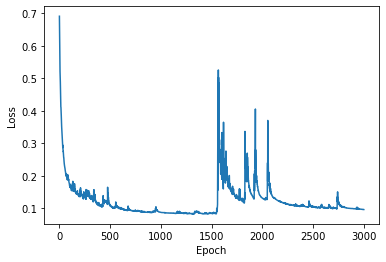

In [25]:
plt.plot(range(epochs),losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [26]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_pred_2 = model.forward(X_test)

In [27]:
y_item = []
for i in range(2622):
  y_item.append(y_pred_2[i].argmax())

In [28]:
y_item = np.array(y_item)

In [29]:
correct = 0
for i in range(2622):
  if y_item[i]==y_test[i]:
    correct = correct + 1
print('Accuracy: {}'.format(correct*100/2622))

Accuracy: 94.39359267734554


In [30]:
X_val_test = df_test.drop(['reason'], axis=1)
y_val_test = df_test['reason']

In [31]:
X_val_test = X_val_test.to_numpy()
X_val_test = torch.FloatTensor(X_val_test)

In [32]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_pred_3 = model.forward(X_val_test)

In [33]:
y_item_2 = []
for i in range(1000):
  y_item_2.append(y_pred_3[i].argmax())

In [34]:
y_item = np.array(y_item)
y_val_test = y_val_test.to_numpy()

In [35]:
correct = 0
for i in range(1000):
  if y_item_2[i]==y_val_test[i]:
    correct = correct + 1
print('Accuracy: {}'.format(correct*100/1000))

Accuracy: 94.7


In [36]:
import torch.nn.functional as nnf

# ...
prob = nnf.softmax(y_pred_2, dim=1)

In [37]:
prob[:,0]

tensor([9.9808e-01, 9.5431e-01, 7.5820e-04,  ..., 9.9907e-01, 1.9037e-03,
        9.9597e-01])

In [38]:
prob2 = nnf.softmax(y_pred_3, dim=1)

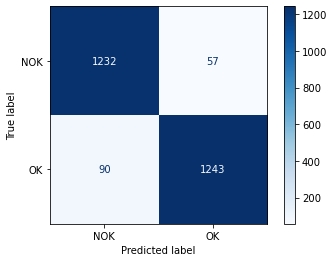

In [39]:
cm = confusion_matrix(y_test,y_item)
classNames = ['NOK','OK']
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classNames)
disp.plot(cmap=plt.cm.Blues)

Confusion Matrix:
 [[1232   57]
 [  90 1243]]
Accuracy:
 0.9439359267734554
Precision:
 0.9561538461538461
Recall:
 0.932483120780195
AUC:
 0.9906374964571244


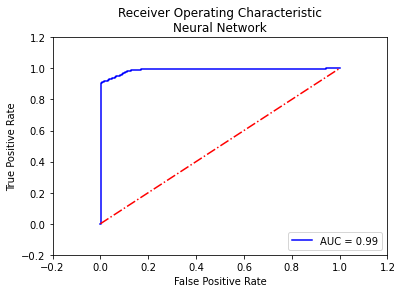

In [40]:
print("Confusion Matrix:\n",confusion_matrix(y_test,y_item))
print("Accuracy:\n",accuracy_score(y_test,y_item))
print("Precision:\n",precision_score(y_test,y_item))
print("Recall:\n",recall_score(y_test,y_item))
print("AUC:\n",roc_auc_score(y_test,prob[:,1]))
auc=roc_auc_score(y_test,prob[:,1])

#plotting the ROC curve
fpr,tpr,thresholds=roc_curve(y_test,prob[:,1])
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nNeural Network')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

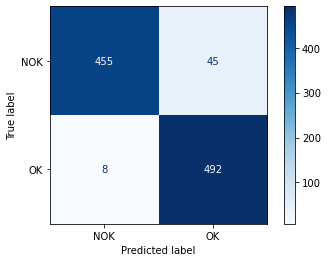

In [41]:
cm = confusion_matrix(y_val_test,y_item_2)
classNames = ['NOK','OK']
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classNames)
disp.plot(cmap=plt.cm.Blues)

Confusion Matrix:
 [[455  45]
 [  8 492]]
Accuracy:
 0.947
Precision:
 0.9162011173184358
Recall:
 0.984
AUC:
 0.931288


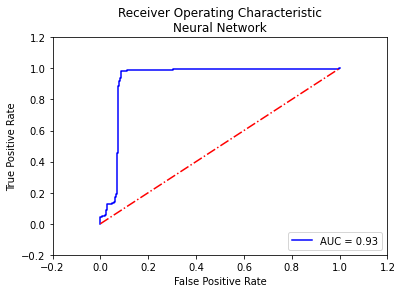

In [43]:
print("Confusion Matrix:\n",confusion_matrix(y_val_test,y_item_2))
print("Accuracy:\n",accuracy_score(y_val_test,y_item_2))
print("Precision:\n",precision_score(y_val_test,y_item_2))
print("Recall:\n",recall_score(y_val_test,y_item_2))
print("AUC:\n",roc_auc_score(y_val_test,prob2[:,1]))
auc=roc_auc_score(y_val_test,prob2[:,1])

#plotting the ROC curve
fpr,tpr,thresholds=roc_curve(y_val_test,prob2[:,1])
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nNeural Network')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()